Выполнил студент группы ББМО-01-23: Панков.Н.О

Цель работы:

1) Загрузить ранее обученную модель на датасете MNIST.

2) Изучить теоретические основы атаки PGD.

3) Реализовать атаку PGD с помощью фреймворка Foolbox.

4) Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

In [2]:
#Устанвока библеотеки foolbox

!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.4 MB/s eta 0:00:00


In [3]:
#Импорт всех необходимых библеотек

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [4]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Точность теста на чистых изображениях: {test_acc:.2%}')

Точность теста на чистых изображениях: 97.64%


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


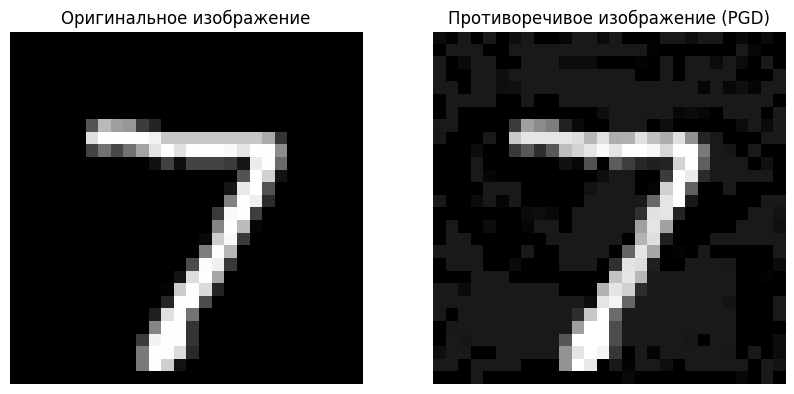

In [7]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = tf.convert_to_tensor(np.argmax(test_labels[0]), dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.LinfPGD()
advs, _, _ = attack(fmodel, image, label[None], epsilons=0.1)

# Визуализация оригинального и противоречивого изображений
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

In [8]:
# Атака на весь тестовый набор
adversarial_images = []
for i in range(len(test_images)):
    img = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    lbl = tf.convert_to_tensor(np.argmax(test_labels[i]), dtype=tf.int64)
    adv, _, _ = attack(fmodel, img, lbl[None], epsilons=0.1)
    adversarial_images.append(adv)

# Конвертация в тензор
adversarial_images = tf.concat(adversarial_images, axis=0)

In [9]:
# Оценка на противоречивых данных
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels, verbose=0)
print(f'Точность на состязательных примерах (PGD): {adversarial_acc:.2%}')

Точность на состязательных примерах (PGD): 7.20%


Вывод:

Модель оказалась крайне уязвимой к атакам PGD (Projected Gradient Descent). Хотя высокая точность в 97,6% на чистых данных демонстрирует её эффективность при стандартных условиях, снижение точности до 7,2% под воздействием PGD свидетельствует о том, что модель практически беззащитна перед малозаметными и целенаправленными изменениями входных данных, которые легко обманывают её.